<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Assuming nltk is set up with necessary datasets
import nltk
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
my_path="/content/drive/MyDrive/CS491/Data/US_Inaugural_Addresses"

In [ ]:
# Define a function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in string.punctuation and word not in stopwords.words('english')]
    return tokens



In [ ]:
# Assuming all your text files are in the 'inauguration_speeches' directory
directory = my_path
all_files = os.listdir(directory)

sentences = [] # This will store all sentences needed for training

for filename in all_files:
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        # Preprocess and tokenize the text
        tokens = preprocess_text(text)
        sentences.append(tokens)

In [ ]:
# sentences[5]

In [ ]:
##How many CPU cores are availabe in Colab?
!cat /proc/cpuinfo | grep processor | wc -l

2


In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.save("presidential_speeches_word2vec.model")




In [ ]:
len(model.wv.index_to_key)

9509

In [ ]:
# After training, you can use the model to find similar words, etc.
model.wv.most_similar('freedom',topn=3)

[('without', 0.9999086260795593),
 ('people', 0.9999086260795593),
 ('every', 0.9999027848243713)]

In [ ]:
# Example words
word1 = "women"
word2 = "vote"
word3="liberty"

# Get the vector for each word
vector1 = model.wv[word1]
vector2 = model.wv[word2]
vector3=model.wv[word3]

# Add the vectors
added_vector = vector1 + vector2+vector3

# You can now use the resulting vector to find similar words, for example
similar_words = model.wv.similar_by_vector(added_vector,topn=5)

print(similar_words)


[('liberty', 0.9998981952667236), ('nation', 0.9998500347137451), ('people', 0.9998379349708557), ('may', 0.9998315572738647), ('country', 0.9998300671577454)]


In [53]:
# Extract all word vectors, this example uses a subset for clarity
words = list(model.wv.index_to_key[-500:])  # Adjust the slice for the number of words you want
word_vectors = [model.wv[word] for word in words]


In [54]:
len(words)

500

In [55]:
import numpy as np
from sklearn.decomposition import PCA

# Convert word vectors into a 2D array of shape (number_of_words, dimensions_of_vectors)
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors_matrix)


In [56]:
##Filtering out points that have outlier coordinates, in order prevent plot scaling problems

# Assuming word_vectors is a list of [x, y] points
word_vectors = np.array(word_vectors)

# Calculate Q1, Q3, and IQR for x and y coordinates
Q1_x, Q3_x = np.percentile(word_vectors[:, 0], [25, 75])
IQR_x = Q3_x - Q1_x
Q1_y, Q3_y = np.percentile(word_vectors[:, 1], [25, 75])
IQR_y = Q3_y - Q1_y

# Define bounds for outliers
lower_bound_x = Q1_x - 1.5 * IQR_x
upper_bound_x = Q3_x + 1.5 * IQR_x
lower_bound_y = Q1_y - 1.5 * IQR_y
upper_bound_y = Q3_y + 1.5 * IQR_y

# Filter out outliers
filtered_vectors = [vec for vec in word_vectors if (
    lower_bound_x <= vec[0] <= upper_bound_x and
    lower_bound_y <= vec[1] <= upper_bound_y
)]

# If you need to filter the corresponding words as well:
filtered_words = [word for vec, word in zip(word_vectors, words) if (
    lower_bound_x <= vec[0] <= upper_bound_x and
    lower_bound_y <= vec[1] <= upper_bound_y
)]


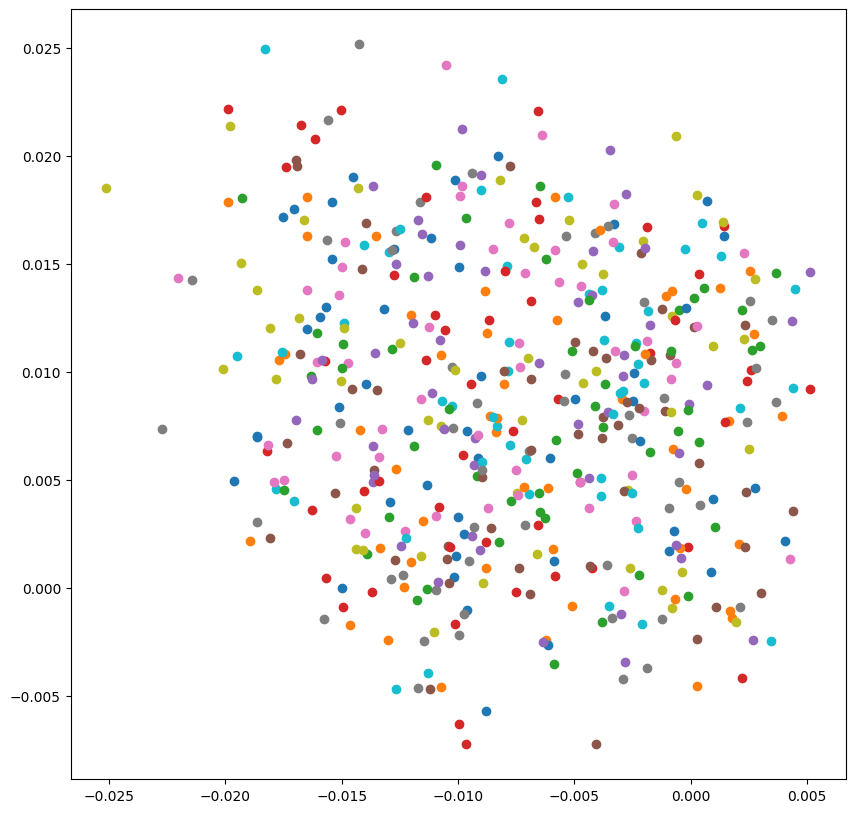

In [57]:
import matplotlib.pyplot as plt


# Ensure filtered_vectors is a numpy array
filtered_vectors = np.array(filtered_vectors)

plt.figure(figsize=(10, 10))

# Iterate over both words and vectors
for vec, word in zip(filtered_vectors, filtered_words):
    plt.scatter(vec[0], vec[1])


plt.show()

